In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.visualization import plot_predictions, plot_model_comparison, plot_feature_importance
from src.models import CustomEncoder

# Import estimators and transformers
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder, PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

# Import predictors
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor,
                              AdaBoostRegressor)

# Import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, GridSearchCV

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

%load_ext autoreload
%autoreload 2

path_processed = '/home/matteo@COPPET/Documents/data_science/projects/housing_prices_firenze/data/processed/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Modeling

## 1. Loading data

In [61]:
X_train = pd.read_csv(path_processed+'X_train.csv')
X_test = pd.read_csv(path_processed+'X_test.csv')
y_train = pd.read_csv(path_processed+'y_train.csv').values.ravel()
y_test = pd.read_csv(path_processed+'y_test.csv').values.ravel()
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5656 entries, 0 to 5655
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Superficie                   5656 non-null   float64
 1   Piano                        5594 non-null   object 
 2   Zona                         5656 non-null   object 
 3   Stato                        5506 non-null   object 
 4   Climatizzazione              5656 non-null   object 
 5   Classe_immobile              4874 non-null   object 
 6   Tipo_proprietà               5374 non-null   object 
 7   Tipologia_casa               5656 non-null   object 
 8   Anno_costruzione_bins        4181 non-null   object 
 9   Riscaldamento_A_C            5656 non-null   object 
 10  Tipo_riscaldamento           4441 non-null   object 
 11  Alimentazione_riscaldamento  4238 non-null   object 
 12  Efficienza_energetica        3992 non-null   object 
 13  Ascensore         

## 2. Pre-processing pipelines

In [62]:
# Features
cat_features = X_train.select_dtypes(exclude='float64').columns
num_features = X_train.select_dtypes(include='float64').columns

In [63]:
# Pre-processing pipeline 1
cat_transformer = Pipeline([
    ('imputing', SimpleImputer(strategy='most_frequent')),
    ('oh_encoding', OneHotEncoder(handle_unknown='ignore'))
])

num_transformer = Pipeline([
    ('transformation', PowerTransformer()),
    ('imputing', SimpleImputer(strategy='mean')),
])

preprocessing_pipeline_1 = ColumnTransformer([
    ('categoricals', cat_transformer, cat_features),
    ('numericals', num_transformer, num_features)
],
    remainder='passthrough'
)

In [196]:
# Pre-processing pipeline 2
cat_transformer = Pipeline([
    ('label_encoding', CustomEncoder()),
    ('imputing', IterativeImputer(initial_strategy='most_frequent', max_iter=10, random_state=0)),
])

num_transformer = Pipeline([
    ('transformation', PowerTransformer()),
    ('imputing', IterativeImputer(initial_strategy='mean', max_iter=10, random_state=0))
])

preprocessing_pipeline_2 = ColumnTransformer([
    ('categoricals', cat_transformer, cat_features),
    ('numericals', num_transformer, num_features)
],
    remainder='passthrough'
)

## 3. Model selection

In [6]:
# Seed
rng = np.random.RandomState(14)

# Folds and metrics
num_folds = 5
kf = KFold(num_folds, shuffle=True, random_state=rng).get_n_splits(X_train.values)

scoring = "neg_mean_squared_error"

# Target transformation functions
def func(y):
    return np.log1p(y)

def inverse_func(y):
    return np.expm1(y)

def func_2(y):
    return np.sqrt(y)

def inverse_func_2(y):
    return y**2

### 3.1 First model (benchmarking): ridge regression

#### 3.1.1 Modeling and results

Training RSME: 57,911 EUR
Mean cross-validation RMSE: 59,013 (+/-1,765) EUR


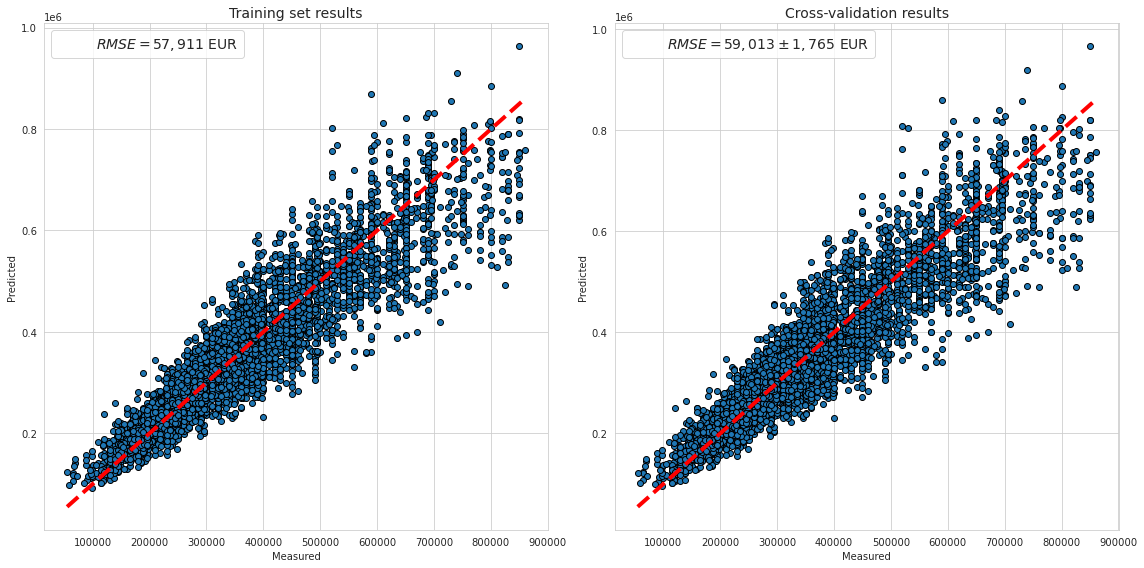

In [65]:
pipe = Pipeline([
    ('preprocessing', preprocessing_pipeline_1),
    ('model', TransformedTargetRegressor(regressor=Ridge(), func=func, inverse_func=inverse_func))
])

# Training set score
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_train)

train_score = np.sqrt(mean_squared_error(y_train, y_pred))
print('Training RSME: {:,.0f} EUR'.format(train_score))

# Cross-validation score
cv_scores = np.sqrt(-cross_val_score(pipe, X_train, y_train, scoring=scoring, cv=kf))
print('Mean cross-validation RMSE: {:,.0f} (+/-{:,.0f}) EUR'.format(np.mean(cv_scores), np.std(cv_scores)))

# Cross-validation predictions
cv_pred = cross_val_predict(pipe, X_train, y_train, cv=kf)

# Plot predicted vs. true values
scores = (
    (r'$RMSE={:,.0f}$'+' EUR').format(train_score),
    (r'$RMSE={:,.0f} \pm {:,.0f}$'+' EUR').format(np.mean(cv_scores), np.std(cv_scores))
         )
pred_plot = plot_predictions(scores, y_pred, cv_pred, y_train)
plt.show()

Considering a mean of our target variable Price of **355'000** EUR and a std of **154'000** EUR, an RMSE of **60'000** EUR isn't too bad.

There isn't a huge difference between the training and cross-validation scores so this model is most probably suffering from high bias. Either the model lacks in complexity despite the number of features in our dataset and is not enough to fit our data well or our features do not have enough **predictive power**.

We will keep these results as a baseline to benchmark from.

#### 3.1.2 Feature importance

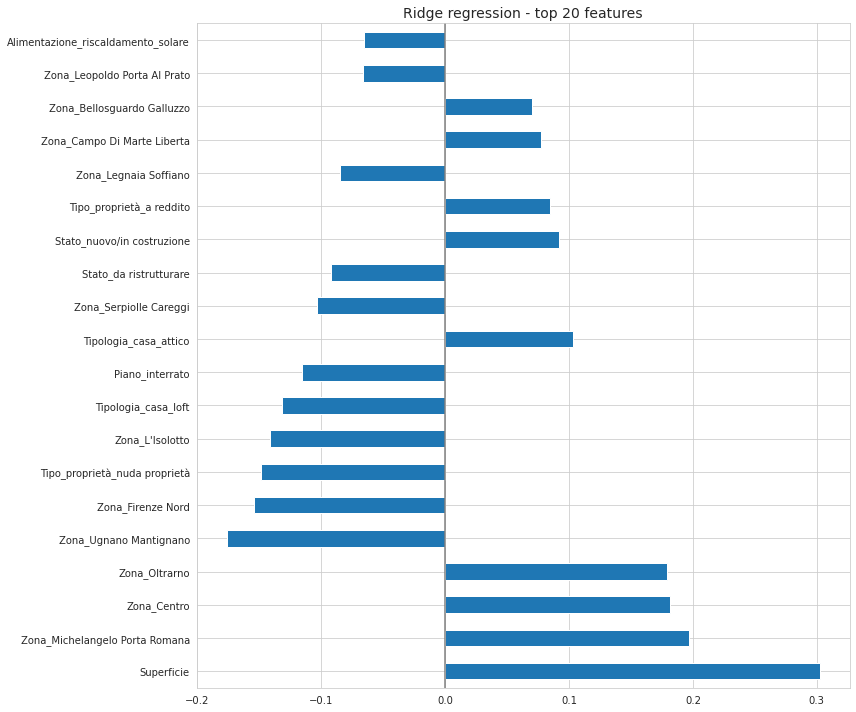

In [66]:
feature_names = (pipe.named_steps['preprocessing']
                     .named_transformers_['categoricals']
                     .named_steps['oh_encoding']
                     .get_feature_names(input_features=cat_features))

feature_names = np.concatenate([feature_names, num_features])

coefs = pd.Series(
    pipe.named_steps['model'].regressor_.coef_,
    index=feature_names
)

# Plot coefficients
plot_coefs = plot_feature_importance('Ridge regression', coefs, 20)
plt.show()
plot_coefs.savefig('/home/matteo@COPPET/Documents/data_science/'
                   'projects/housing_prices_firenze/reports/figures/linear_coefs.png')

Feature importance on our ridge regression model is showing results that make sense, with the **square meters** having the highest coefficient of all the features.

#### 3.1.3 Regularization hyperparameter

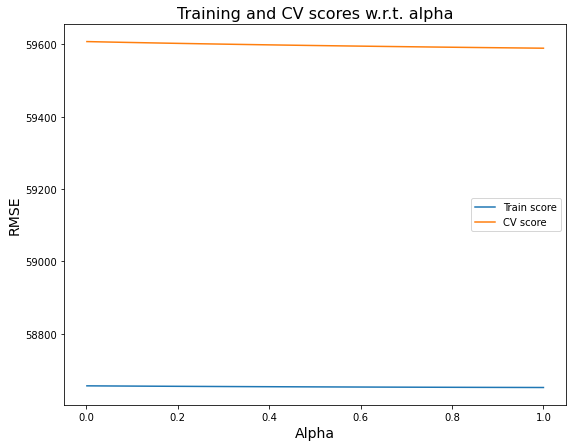

In [322]:
n_alphas = 50
alphas = np.logspace(-3, 0, n_alphas)

train_scores = []
cv_scores = []
for a in alphas:
    model = TransformedTargetRegressor(regressor=Ridge(alpha=a), func=func, inverse_func=inverse_func)
    
    pipe = Pipeline([
    ('preprocessing', preprocessing_pipeline_1),
    ('model', model)
    ])
    
    # Training set score
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_train)
    
    train_scores.append(np.sqrt(mean_squared_error(y_train, y_pred)))
    
    # Cross-validation scores
    scores = np.sqrt(-cross_val_score(pipe, X_train, y_train, scoring=scoring, cv=kf))
    cv_scores.append(np.mean(scores))

# Plot scores w.r.t. 
fig, ax = plt.subplots(figsize=(9, 7))
line1 = ax.plot(alphas, train_scores, label='Train score')
line2 = ax.plot(alphas, cv_scores, label='CV score')
ax.set_title('Training and CV scores w.r.t. alpha', size=16)
ax.set_xlabel('Alpha', size=14)
ax.set_ylabel('RMSE', size=14)
ax.legend()
plt.show()

Not much to see here as the scores to not vary much w.r.t. the regularization hyperparameters. We cannot find a "sweet spot" from this graph.

### 3.2 SVR

Training RSME: 41,838 EUR
Mean cross-validation RMSE: 56,757 EUR


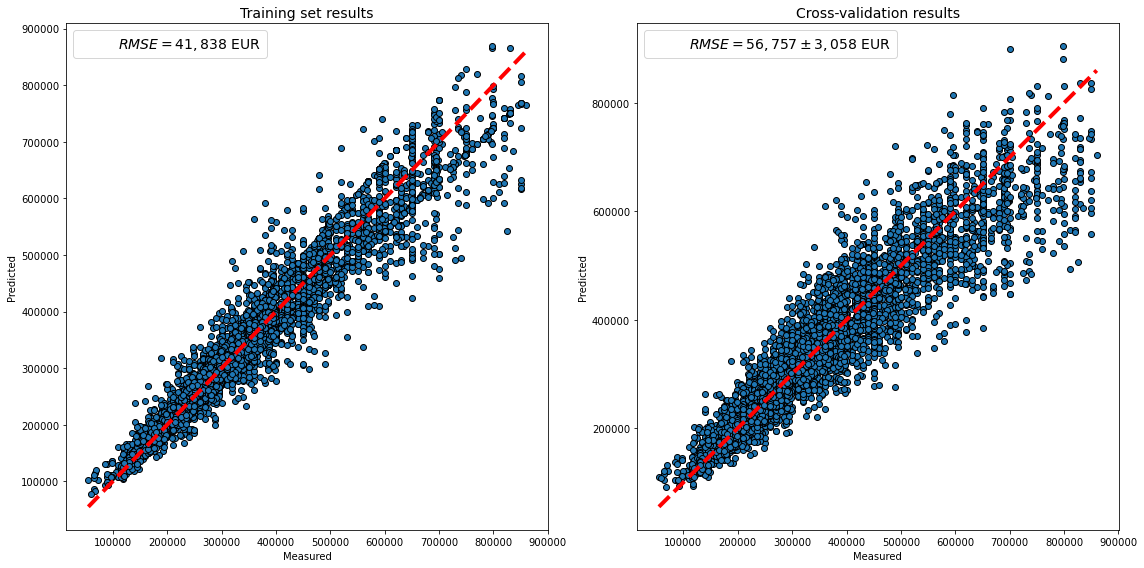

In [350]:
pipe = Pipeline([
    ('preprocessing', preprocessing_pipeline_1),
    ('model', TransformedTargetRegressor(regressor=SVR(), func=func, inverse_func=inverse_func))
])


# Training set score
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_train)

train_score = np.sqrt(mean_squared_error(y_train, y_pred))
print('Training RSME: {:,.0f} EUR'.format(train_score))

# Cross-validation score
cv_scores = np.sqrt(-cross_val_score(pipe, X_train, y_train, scoring=scoring, cv=kf))
print('Mean cross-validation RMSE: {:,.0f} (+/-{:,.0f}) EUR'.format(np.mean(cv_scores), np.std(cv_scores)))

# Cross-validation predictions
cv_pred = cross_val_predict(pipe, X_train, y_train, cv=kf)

# Plot predicted vs. true values
scores = (
    (r'$RMSE={:,.0f}$'+' EUR').format(train_score),
    (r'$RMSE={:,.0f} \pm {:,.0f}$'+' EUR').format(np.mean(cv_scores), np.std(cv_scores))
         )
pred_plot = plot_predictions(scores, y_pred, cv_pred, y_train)
plt.show()

The results from this non-linear SVR model are better than our benchmark. The lower score on the training set compared to the CV score could be an indication of slight overfitting but we will look into this later.

### 3.3 Random forest

#### 3.3.1 Modeling and results

Training RSME: 21,683 EUR
Mean cross-validation RMSE: 57,046 (+/-1,181) EUR


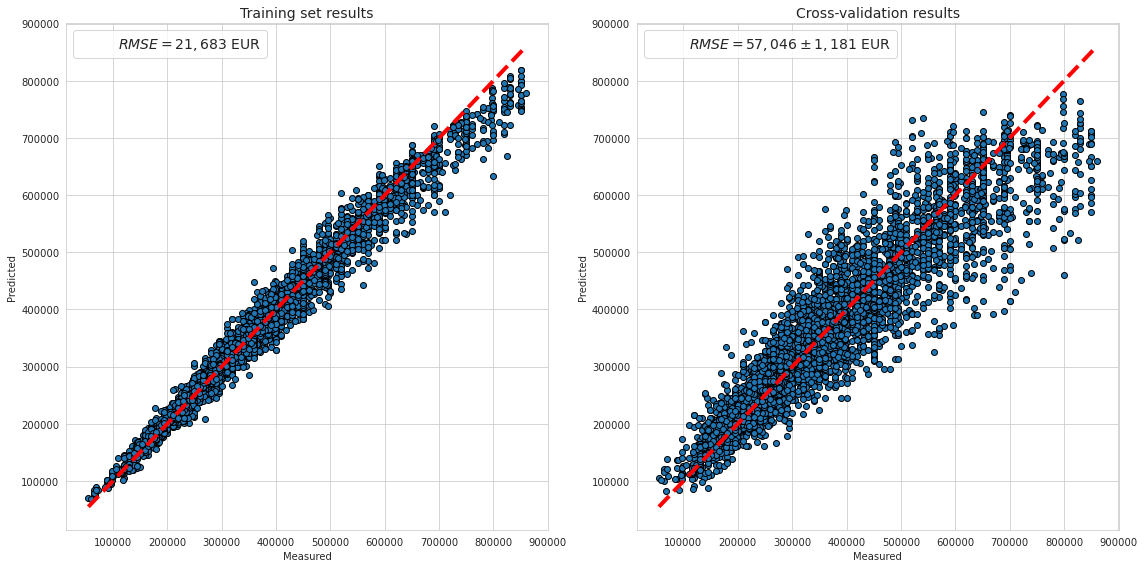

In [67]:
pipe = Pipeline([
    ('preprocessing', preprocessing_pipeline_1),
    ('model', TransformedTargetRegressor(regressor=RandomForestRegressor(random_state=rng),
                                         func=func,
                                         inverse_func=inverse_func))
])

# Training set score
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_train)

train_score = np.sqrt(mean_squared_error(y_train, y_pred))
print('Training RSME: {:,.0f} EUR'.format(train_score))

# Cross-validation score
cv_scores = np.sqrt(-cross_val_score(pipe, X_train, y_train, scoring=scoring, cv=kf))
print('Mean cross-validation RMSE: {:,.0f} (+/-{:,.0f}) EUR'.format(np.mean(cv_scores), np.std(cv_scores)))

# Cross-validation predictions
cv_pred = cross_val_predict(pipe, X_train, y_train, cv=kf)

# Plot predicted vs. true values
scores = (
    (r'$RMSE={:,.0f}$'+' EUR').format(train_score),
    (r'$RMSE={:,.0f} \pm {:,.0f}$'+' EUR').format(np.mean(cv_scores), np.std(cv_scores))
         )
pred_plot = plot_predictions(scores, y_pred, cv_pred, y_train)
plt.show()

This model yields much better results on the training set meaning that it most probably suffers from high variance.

We will surely need to regularize the model to prevent it from overfitting the training data and allow it to generalize well to data it hasn't yet seen (CV/test set). We will do this via hyperparameter tuning.

#### 3.3.2 Feature importances

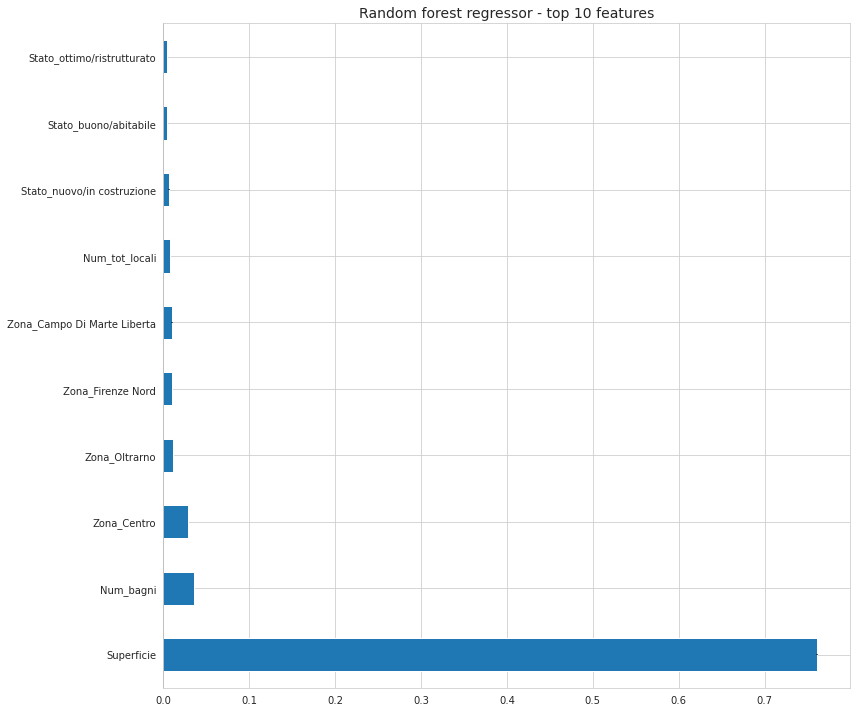

In [68]:
feature_names = (pipe.named_steps['preprocessing']
                     .named_transformers_['categoricals']
                     .named_steps['oh_encoding']
                     .get_feature_names(input_features=cat_features))

feature_names = np.concatenate([feature_names, num_features])

feature_importances = pd.DataFrame(
    {'Feature_importances': pipe.named_steps['model'].regressor_.feature_importances_,
     'Std': np.std([tree.feature_importances_ for tree in pipe.named_steps['model'].regressor_.estimators_],
                   axis=0)
    },
     index=feature_names
)

features = feature_importances['Feature_importances']
std = feature_importances['Std']

# Plot feature importances
plot_importances = plot_feature_importance('Random forest regressor', features, 10, std)
plt.show()
plot_importances.savefig('/home/matteo@COPPET/Documents/data_science/'
                         'projects/housing_prices_firenze/reports/figures/feature_importance.png')

Again, the results from feature importance are coherent with what we would expect, with the square meters being the most influencial feature for prediction.

### 3.4 Gradient boosting

#### 3.4.1 Modeling and results

Training RSME: 50,669 EUR
Mean cross-validation RMSE: 56,721 (+/-2,300) EUR


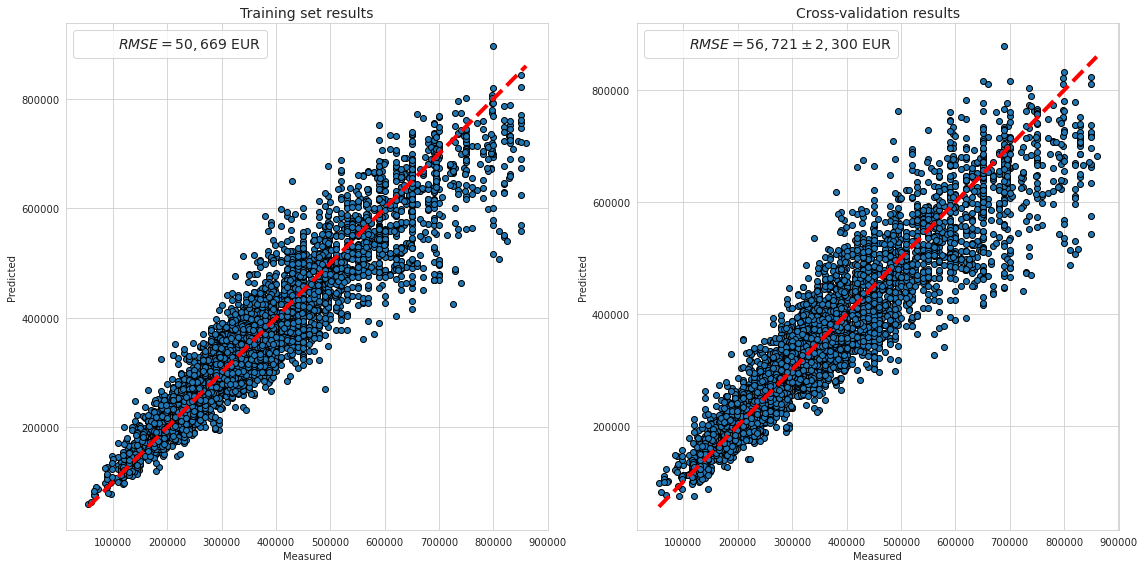

In [411]:
pipe = Pipeline([
    ('preprocessing', preprocessing_pipeline_1),
    ('model', TransformedTargetRegressor(
        regressor=GradientBoostingRegressor(
            n_estimators=1000,
            validation_fraction=0.2,
            n_iter_no_change=300,
            tol=0.01,
            random_state=rng
        ),
        func=func,
        inverse_func=inverse_func))
])

# Training set score
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_train)

train_score = np.sqrt(mean_squared_error(y_train, y_pred))
print('Training RSME: {:,.0f} EUR'.format(train_score))

# Cross-validation score
cv_scores = np.sqrt(-cross_val_score(pipe, X_train, y_train, scoring=scoring, cv=kf))
print('Mean cross-validation RMSE: {:,.0f} (+/-{:,.0f}) EUR'.format(np.mean(cv_scores), np.std(cv_scores)))

# Cross-validation predictions
cv_pred = cross_val_predict(pipe, X_train, y_train, cv=kf)

# Plot predicted vs. true values
scores = (
    (r'$RMSE={:,.0f}$'+' EUR').format(train_score),
    (r'$RMSE={:,.0f} \pm {:,.0f}$'+' EUR').format(np.mean(cv_scores), np.std(cv_scores))
         )
pred_plot = plot_predictions(scores, y_pred, cv_pred, y_train)
plt.show()

Gradient boosting with early stopping shows no signs of overfitting and could be an interesting choice for the final model. In the next section I've plotted the scores w.r.t. the early stopping parameter `no_iter_no_change` to find the right value to use for the model. 

#### 3.4.2 Early stopping hyperparameter

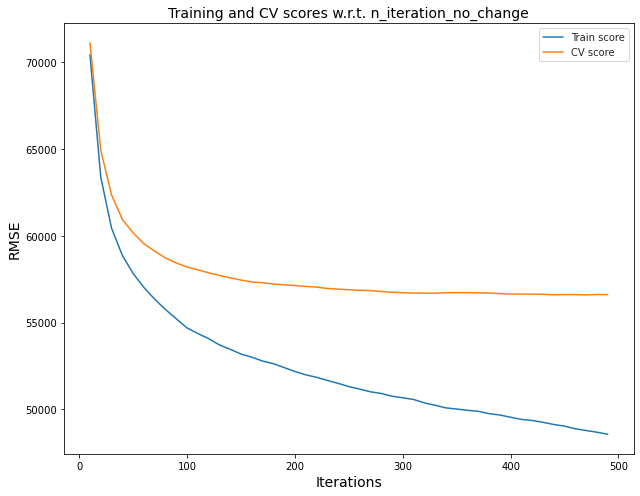

In [19]:
iters = np.arange(10, 500, 10)
train_scores = []
cv_scores = []

for i in iters:
    model = TransformedTargetRegressor(
        regressor=GradientBoostingRegressor(
            n_estimators=1000,
            validation_fraction=0.2,
            n_iter_no_change=i,
            tol=0.01,
            random_state=rng),
        func=func,
        inverse_func=inverse_func
    )
    
    pipe = Pipeline([
    ('preprocessing', preprocessing_pipeline_1),
    ('model', model)
    ])
    
    # Training set score
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_train)
    
    train_scores.append(np.sqrt(mean_squared_error(y_train, y_pred)))
    
    # Cross-validation scores
    scores = np.sqrt(-cross_val_score(pipe, X_train, y_train, scoring=scoring, cv=kf))
    cv_scores.append(np.mean(scores))

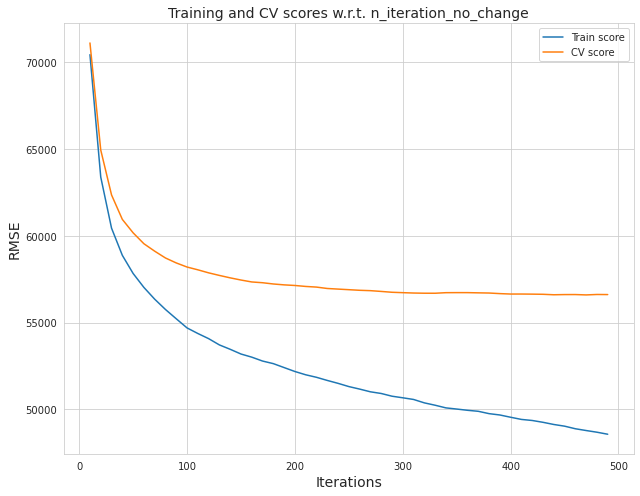

In [20]:
# Plot scores w.r.t. n_iteration_no_change
fig, ax = plt.subplots(figsize=(9, 7))
line1 = sns.lineplot(x=iters, y=train_scores, label='Train score')
line2 = sns.lineplot(x=iters, y=cv_scores, label='CV score')
sns.set_style('whitegrid')
ax.set_title('Training and CV scores w.r.t. n_iteration_no_change', size=14)
ax.set_xlabel('Iterations', size=14)
ax.set_ylabel('RMSE', size=14)
ax.legend()
plt.tight_layout()
plt.show()

Clearly, a good value for this parameter would be roughly 300 iterations.

### 3.5 Other models

#### 3.5.1 Modeling and results

In [42]:
# Define algorithms
models = []
models.append(('RIDG', Ridge()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('SVR', SVR()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('RDMF', RandomForestRegressor(random_state=rng)))
models.append(('EXTR', ExtraTreesRegressor(random_state=rng)))
models.append(('GRBO', GradientBoostingRegressor(n_estimators=1000,
                                                 validation_fraction=0.2,
                                                 n_iter_no_change=300,
                                                 tol=0.01,
                                                 random_state=rng)))
models.append(('ADA', AdaBoostRegressor(random_state=rng)))

train_results = []
cv_results = []
names = []
for name, model in models:
    
    # Define pipeline
    pipe = Pipeline([
        ('preprocessing', preprocessing_pipeline_1),
        ('model', TransformedTargetRegressor(regressor=model, func=func, inverse_func=inverse_func))
    ])
    
    # Training score
    pipe.fit(X_train, y_train)
    train_pred = pipe.predict(X_train)
    
    train_score = np.sqrt(mean_squared_error(y_train, train_pred))
    train_results.append(train_score)

    # Cross-validation scores
    cv_scores = np.sqrt(-cross_val_score(pipe, X_train, y_train, scoring=scoring, cv=kf))
    cv_results.append(cv_scores)
    
    # Append names and print
    names.append(name)
    msg = f'{name} CV RMSE: {np.mean(cv_scores):,.0f} (+/-{np.std(cv_scores):,.0f}) EUR'
    print(msg)

RIDG CV RMSE: 59,589 (+/-1,591) EUR
KNN CV RMSE: 78,259 (+/-3,670) EUR
SVR CV RMSE: 56,757 (+/-3,058) EUR
CART CV RMSE: 78,248 (+/-4,831) EUR
RDMF CV RMSE: 56,880 (+/-2,973) EUR
EXTR CV RMSE: 57,071 (+/-3,404) EUR
GRBO CV RMSE: 56,721 (+/-2,300) EUR
ADA CV RMSE: 75,446 (+/-1,755) EUR


#### 3.5.2 Comparing algorithms

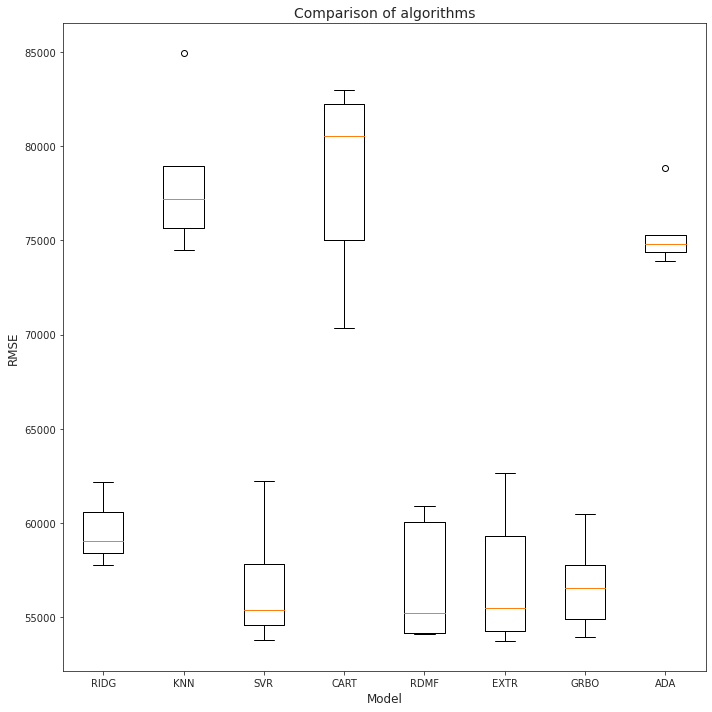

In [47]:
model_comp = plot_model_comparison(cv_results, names)
sns.set_style('white')
plt.show()
model_comp.savefig('/home/matteo@COPPET/Documents/data_science/projects/'
                   'housing_prices_firenze/reports/figures/algo_comparison.png')

The SVR, RDMF and EXTR seem to yield the best results out of all of the models. We'll do some tuning on the SVR and RDMF models next!

## 4. Hyperparameter tuning

### 4.1 SVR

In [368]:
pipe = Pipeline([
    ('preprocessing', preprocessing_pipeline_1),
    ('model', TransformedTargetRegressor(regressor=SVR(), func=func, inverse_func=inverse_func))
])

param_grid = {
    'model__regressor__C': 10. ** np.arange(-3, 3),
    'model__regressor__gamma': 10. ** np.arange(-3, 3),
}

grid_search = GridSearchCV(pipe, param_grid, scoring=scoring, cv=kf)
grid_search.fit(X_train, y_train)

pipe = grid_search.best_estimator_
pipe

Training RSME: 53,075 EUR
Mean cross-validation RMSE: 57,260 (+/-2,048) EUR


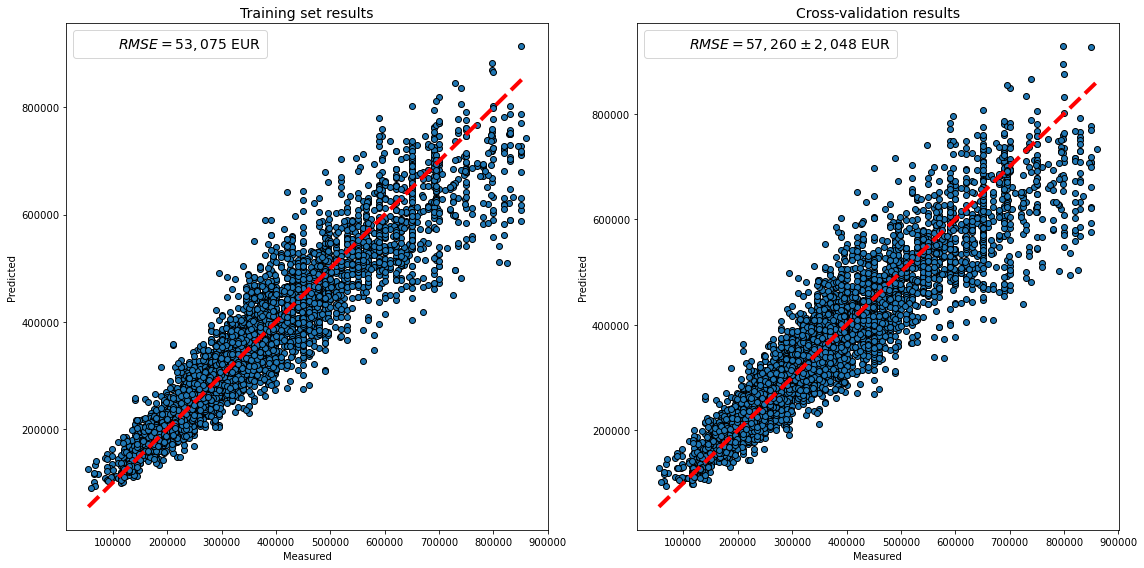

In [371]:
# Training set score
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_train)

train_score = np.sqrt(mean_squared_error(y_train, y_pred))
print('Training RSME: {:,.0f} EUR'.format(train_score))

# Cross-validation score
cv_scores = np.sqrt(-cross_val_score(pipe, X_train, y_train, scoring=scoring, cv=kf))
print('Mean cross-validation RMSE: {:,.0f} (+/-{:,.0f}) EUR'.format(np.mean(cv_scores), np.std(cv_scores)))

# Cross-validation predictions
cv_pred = cross_val_predict(pipe, X_train, y_train, cv=kf)

# Plot predicted vs. true values
scores = (
    (r'$RMSE={:,.0f}$'+' EUR').format(train_score),
    (r'$RMSE={:,.0f} \pm {:,.0f}$'+' EUR').format(np.mean(cv_scores), np.std(cv_scores))
         )
pred_plot = plot_predictions(scores, y_pred, cv_pred, y_train)
plt.show()

### 4.2 Random forest regressor

In [48]:
pipe = Pipeline([
    ('preprocessing', preprocessing_pipeline_1),
    ('model', TransformedTargetRegressor(regressor=RandomForestRegressor(random_state=rng),
                                         func=func,
                                         inverse_func=inverse_func))
])

param_grid = {
    'model__regressor__n_estimators': [50, 100, 200, 300],
    'model__regressor__min_samples_split': [2, 8, 10],
    'model__regressor__max_features': [2, 5, 10]
}

grid_search = GridSearchCV(pipe, param_grid, scoring=scoring, cv=kf)
grid_search.fit(X_train, y_train)

pipe = grid_search.best_estimator_
pipe

Training RSME: 24,293 EUR
Mean cross-validation RMSE: 63,040 (+/-2,874) EUR


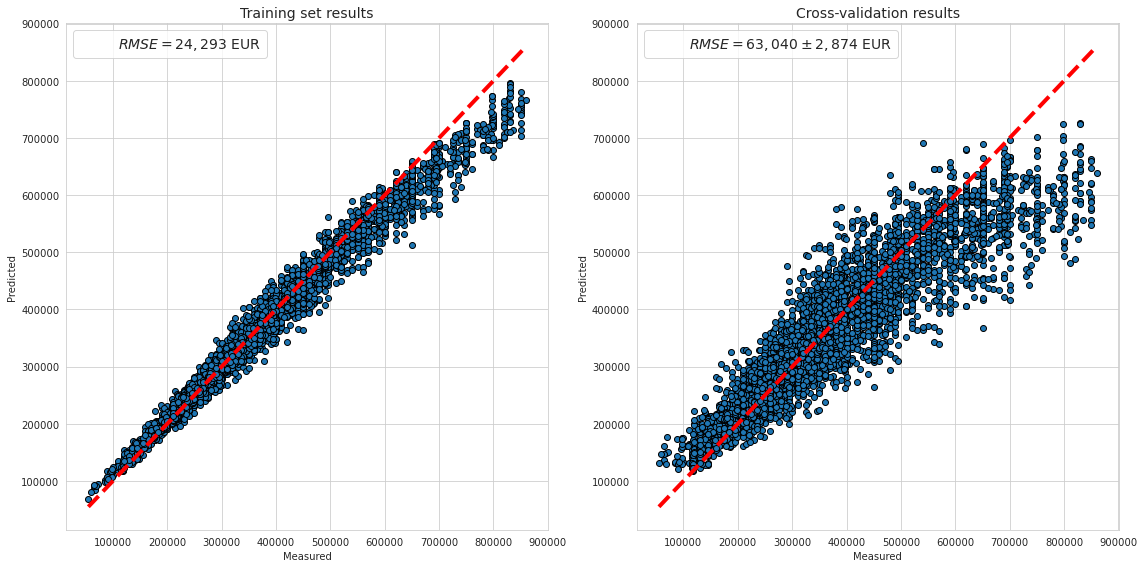

In [50]:
# Training set score
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_train)

train_score = np.sqrt(mean_squared_error(y_train, y_pred))
print('Training RSME: {:,.0f} EUR'.format(train_score))

# Cross-validation score
cv_scores = np.sqrt(-cross_val_score(pipe, X_train, y_train, scoring=scoring, cv=kf))
print('Mean cross-validation RMSE: {:,.0f} (+/-{:,.0f}) EUR'.format(np.mean(cv_scores), np.std(cv_scores)))

# Cross-validation predictions
cv_pred = cross_val_predict(pipe, X_train, y_train, cv=kf)

# Plot predicted vs. true values
scores = (
    (r'$RMSE={:,.0f}$'+' EUR').format(train_score),
    (r'$RMSE={:,.0f} \pm {:,.0f}$'+' EUR').format(np.mean(cv_scores), np.std(cv_scores))
         )
pred_plot = plot_predictions(scores, y_pred, cv_pred, y_train)
plt.show()